In [ ]:
!pip install tensorflow==2.16.1
!pip install keras==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import string
import re
import unicodedata
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
# Load data
data = pd.read_csv("chat_health.csv")
data = data.head(2000)

# Define function to convert unicode to ASCII
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

# Define text cleaning function
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("(\\W)"," ",text)
    text = re.sub('\S*\d\S*\s*','', text)
    return text

data["short_question"] = data.short_question.apply(clean_text)
data["short_answer"] = data.short_answer.apply(clean_text)

# Text preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['short_question'].tolist() + data['short_answer'].tolist())
vocab_size = len(tokenizer.word_index) + 1

questions_seq = tokenizer.texts_to_sequences(data['short_question'])
answers_seq = tokenizer.texts_to_sequences(data['short_answer'])

max_length = max(max(len(x) for x in questions_seq), max(len(x) for x in answers_seq))
questions_padded = pad_sequences(questions_seq, maxlen=max_length, padding='post')
answers_padded = pad_sequences(answers_seq, maxlen=max_length, padding='post')

# Split dataset
train_questions, val_questions, train_answers, val_answers = train_test_split(
    questions_padded, answers_padded, test_size=0.1, random_state=42)

# Prepare training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_questions, train_answers))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(16).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_questions, val_answers))
val_dataset = val_dataset.batch(16).repeat()

# Build model
model = Sequential([
    Embedding(vocab_size, 128),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    Dense(vocab_size, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adjust batch_size or directly use the entire dataset
batch_size = 16
class CombinedStoppingCallback(Callback):
    def __init__(self, loss_threshold=0.01, improvement_threshold=0.01, patience=200):
        super(CombinedStoppingCallback, self).__init__()
        self.loss_threshold = loss_threshold  # Stop training if loss is below this value
        self.improvement_threshold = improvement_threshold  # Consider stopping if improvement is less than this value
        self.patience = patience  # Max consecutive epochs to wait before deciding to stop
        self.best_loss = float('inf')
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return

        # Check if the loss has reached below the threshold
        if current_loss < self.loss_threshold:
            print(f"\nEpoch {epoch}: Stopping training as loss {current_loss} is below threshold {self.loss_threshold}.")
            self.model.stop_training = True

        # Check if there is a significant improvement in loss
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_epoch = epoch
        else:
            # Check if it has been 'patience' epochs since the last best loss and the improvement is not enough
            if (epoch - self.best_epoch) >= self.patience and (self.best_loss - current_loss) < self.improvement_threshold:
                print(f"\nEpoch {epoch}: No significant improvement in loss for {self.patience} epochs. Stopping training.")
                self.model.stop_training = True

# Create an instance of CombinedStoppingCallback
stopping_callback = CombinedStoppingCallback(loss_threshold=1.7, improvement_threshold=0.1, patience=20)

# Use the model and save training history
history = model.fit(
    train_dataset,
    epochs=2000,
    steps_per_epoch=max(1, len(train_questions) // batch_size),
    validation_data=val_dataset,
    validation_steps=max(1, len(val_questions) // batch_size),
    callbacks=[stopping_callback]
)

Epoch 1/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.4695 - loss: 4.9200 - val_accuracy: 0.5076 - val_loss: 3.7853
Epoch 2/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5330 - loss: 3.4758 - val_accuracy: 0.5019 - val_loss: 3.9290
Epoch 3/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.5240 - loss: 3.5449 - val_accuracy: 0.5024 - val_loss: 3.8584
Epoch 4/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5266 - loss: 3.4888 - val_accuracy: 0.5060 - val_loss: 3.8100
Epoch 5/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5301 - loss: 3.4103 - val_accuracy: 0.5120 - val_loss: 3.9015
Epoch 6/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5180 - loss: 3.4664 - val_accuracy: 0.5078 - val_loss: 3.8418
Epoch 7/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5211 - loss: 3.4252 - val_accuracy: 0.5030 - val_loss: 3.9649
Epoch 8/2000
112/112 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5294 - loss: 3

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 62, 128)             │         791,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 62, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 62, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 62, 6182)            │       3,171,366 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,982,260 (72.41 MB)

 Trainable params: 6,327,078 (24.14 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 12,654,158 (48.27 MB)

In [ ]:
model.save_weights('LSTM_2000.weights.h5')


# save Tokenizer
import pickle
with open('tokenizer_LSTM_2000.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files
files.download('LSTM_2000.weights.h5')
files.download('tokenizer_LSTM_2000.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
vocab_size

6182

In [ ]:
max_length

62

In [ ]:
from tensorflow.keras.models import load_model
import pickle


model1  = Sequential([
    Embedding(vocab_size, 128),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    Dense(vocab_size, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model1.build(input_shape=(None, max_length))

model1.load_weights('my_model_weights.weights.h5')
model1.summary()

In [ ]:
# generate answer
def generate_answer(question,model):
    question_seq = tokenizer.texts_to_sequences([question])
    question_padded = pad_sequences(question_seq, maxlen=max_length, padding='post')
    prediction = model.predict(question_padded)
    predicted_indices = np.argmax(prediction, axis=-1)[0]
    predicted_words = ' '.join([tokenizer.index_word[i] for i in predicted_indices if i != 0])
    return predicted_words

In [ ]:
testData = pd.read_csv('chat_health.csv').head(50)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
testData['generated_answer'] = testData['short_question'].head(50).apply(lambda q: generate_answer(q, model))

references = testData['short_answer'].apply(lambda a: [a.split()]).tolist()
candidates = testData['generated_answer'].apply(lambda a: a.split()).tolist()

bleu_score = corpus_bleu(references, candidates)
print("BLEU Score:", bleu_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1

In [ ]:
import time
start_time = time.time()
testData['generated_answer'] = testData['short_question'].head(50).apply(lambda q: generate_answer(q, model))
end_time = time.time()
response_time = end_time - start_time
average_response_time = response_time / 50

print(f"Average response time per record: {average_response_time} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

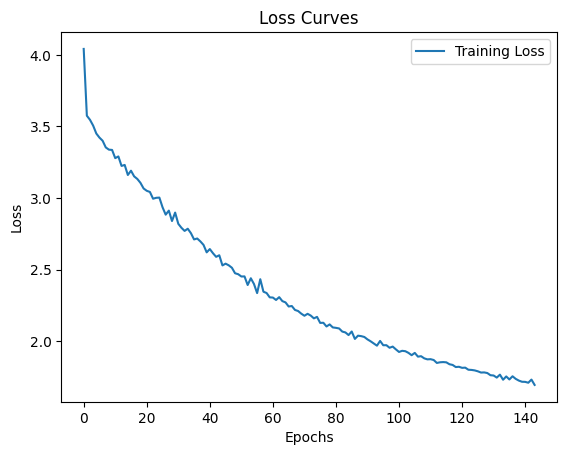

In [ ]:
import matplotlib.pyplot as plt
# Plotting loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Plotting loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plotting accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curves')
plt.show()